In [1]:
import classes
import functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

In [2]:
def get_data_from_folder(mypath):
    """
    @in: het adres van een folder waaruit data getrokken wordt
    @out:   een lijst met namen van de files
            een datalijst: datalijst[experiment] = np.array([ [tijden (sec)],  [spannning CH1 (V)], [spanning CH2 (V)] ])
    
    """
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
    datalijst = []

    for filenaam in onlyfiles:
        adres = mypath+'/'+filenaam
        file = open(adres, 'rt')
        data = file.read()
        file.close()
        data = data.replace(',','.') #ga naar deftige decimaalseparators
        inhoud = data.split('s	V	V')[1].split('\n')
        inhoudlijst = []
        #steek het in een lijst
        for regel in inhoud:
            if regel != '':
                lijst = regel.split('	')
                lijst = [float(elem) for elem in lijst]
                inhoudlijst.append(lijst.copy())
        inhoudlijst = np.array(inhoudlijst).T
        datalijst.append(inhoudlijst.copy())
    return onlyfiles, datalijst


def blokgolf(x, parameters): #een blokgolf met grootte G, frequentie f en offset x0, rond evenwichtspunt E
    f, G,  x0, E = parameters
    a = 2/f
    out = []
    for xval in x:
        xi = xval - x0
        periode = 1
        while not (periode-1)*a <= xi < periode*a:
            if xi < periode*a:
                periode -= 1
            else:
                periode += 1
        out.append(E + G*(-1)**periode)
    return np.array(out)

def sinus(x, parameters):
    A, k, phi, C = parameters
    return A*np.sin(k*x+phi)+C

def spanning_RLC(omega, parameters):
    V0, R, L, C = parameters
    spanning = V0*R/np.sqrt(R**2+(omega*L-1/(omega*C)**2))
    return spanning

def fase_RLC(omega, parameters):
    R, L, C = parameters
    fase = np.arctan((1-omega**2*L*C)/(omega*R*C))
    return fase

def fit_blokgolf(xvals, yvals, invalslist, limieten = None):
    def invals(x,y):
        return invalslist
    fig, ax = plt.subplots(1,1,figsize = (15,5))
    Xval = np.linspace(0,5,1000)
    print('invals',invalslist)
    ax.errorbar(xvals, yvals, yerr = np.full(np.shape(yvals), 0.1), linestyle = '',label = 'data', marker = '')
    ax.plot(Xval, blokgolf(Xval, invalslist), label = 'invals')
    plt.tight_layout()
    ax.legend()
    plt.show()
    print('broer fit gewoon')
    outp = functies.fit(["f",'G',"x_0",'E'], blokgolf, invals, xvals, yvals, initial_range=limieten, y_err = np.full(np.shape(yvals), 5), detailed_logs = False, minimizemethod='fuck you')
    parameterwaarden = [param[0] for param in outp]
    fig, ax = plt.subplots(1,1,)
    Xval = np.linspace(0,5,1000)
    ax.scatter(xvals, yvals, linestyle = '',label = 'data')
    ax.plot(Xval, blokgolf(Xval, parameterwaarden), label = 'model')
    plt.tight_layout()
    ax.legend()
    plt.show()

    return outp

def fit_sinus(xvals, yvals, yerr, freqgok = 1, plotting = False, detailed_logs = False):
    #bepaal initiele waarden
    maximum = max(yvals)
    minimum = min(yvals)
    amplitude = (maximum - minimum)/2
    C = (maximum + minimum)/2
    if yvals[0] <= yvals[1]:
        if -1 <= (yvals[0] - C)/amplitude <= 1:
            phi = np.arcsin( (yvals[0] - C)/amplitude )
        else:
            phi = np.arcsin(yvals[0]/amplitude )
            C = 0
    else:
        if -1 <= (yvals[0] - C)/amplitude <= 1:
            phi = np.pi - np.arcsin( (yvals[0] - C)/amplitude )
        else:
            phi = np.pi - np.arcsin( yvals[0]/amplitude )
            C = 0

    def invals(x,y):
        return [amplitude, 2*np.pi*freqgok, phi, C]
    outp = functies.fit(['A','k','phi','C'], sinus, invals, xvals, yvals, y_err = yerr, detailed_logs=detailed_logs, fuck_CPU = True)
    plotparams = [elem[0] for elem in outp]
    if plotting:
        fig, ax = plt.subplots(1,1)
        ax.errorbar(xvals, yvals, yerr=yerr, linestyle = '', label = 'data')
        T = np.linspace(min(xvals),max(xvals),1000)
        ax.plot(T, sinus(T,plotparams),label = 'model')
        #ax.plot(T, sinus(T, invals(0,0)), label = 'invals')
        ax.legend()
        ax.set_xlabel('tijd (s)')
        ax.set_ylabel('spanning (mV of zo)')
        plt.tight_layout()
        plt.show()
    return outp

def fit_spanning_RLC(omegavals, yvals, omegaerr, yerr, invals = [1,1,1,1]):
    def initvals(x,y): #fix deze initial values
        return invals
    outp = functies.fit_2D(['V0', 'R', 'L', 'C'], spanning_RLC, initvals, omegavals, yvals, omegaerr, yerr)
    return outp

def fit_fase_RLC(omegavals, fase, omegaerr, faseerr, invals = [1,1,1], bounds = None):
    def initvals(x,y):
        return invals
    outp = functies.fit_2D(['R', 'L', 'C'], fase_RLC, initvals, omegavals, fase, omegaerr, faseerr, bounds = bounds)
    return outp

def fix_enkelzijdige_fout(outp):
    """
    @in: de output van een functies.fit
    @out: hetzelfde maar de fouten zijn geen tuples meer
    """
    for indx in range(len(outp)):
        if type(outp[indx][1]) == tuple:
            outp[indx][1] = (abs(outp[indx][1][0])+abs(outp[indx][1][1]))/2
    return outp

def plot_fase_RLC_gelineariseerd(omega, phi, omega_err, phi_err, params):
    """
    @in: is wel duidelijk denk ik 
    """
    R = params[0][0]
    L = params[1][0]
    C = params[2][0]
    omega = np.array(omega)
    omega_err = np.array(omega_err)
    phi = np.array(phi)
    phi_err = np.array(phi_err)
    tanphi = np.tan(phi)
    tanphi_err = phi_err/(np.cos(phi)**2)
    rechterlid = (1-omega**2*L*C)/(omega*R*C)
    rechterlid_err = np.abs((1+omega**2*L*C)/(omega**2*R*C)*omega_err)

    omegalinspace = np.linspace(0,max(omega),1000)
    tanphilinspace = (1-omegalinspace**2*L*C)/(omegalinspace*R*C)
    fig, ax = plt.subplots(1,1,figsize = (10,10))
    ax.set_title('gelineariseerde plot van de fase')
    ax.set_ylabel('tan($\\phi$)')
    ax.set_xlabel('$\\frac{1-\\omega^2RC}{\\omega R C}$')
    ax.errorbar(rechterlid, tanphi, xerr=rechterlid_err, yerr=tanphi_err, linestyle = '', label = 'data')
    ax.plot(tanphilinspace,tanphilinspace,label = 'model')
    ax.legend()
    plt.tight_layout()
    plt.show()
    

In [3]:
#kapot
"""
mypath = "RLC proef/RC"
namen, datalijst = get_data_from_folder(mypath)
freqgoks = [4.2,2]
verschuivingen = [0, 0]
limietlijst = [[(1,6), (5,7), (0,2),(-1,1)], None]
for indx in range(len(namen)):
    top = max(datalijst[indx][1])
    bot = min(datalijst[indx][1])
    invalslist = [freqgoks[indx], (top-bot)/2, verschuivingen[indx], (top+bot)/2]
    fit_blokgolf(datalijst[indx][0], datalijst[indx][1], invalslist, limieten = limietlijst[indx])"""

'\nmypath = "RLC proef/RC"\nnamen, datalijst = get_data_from_folder(mypath)\nfreqgoks = [4.2,2]\nverschuivingen = [0, 0]\nlimietlijst = [[(1,6), (5,7), (0,2),(-1,1)], None]\nfor indx in range(len(namen)):\n    top = max(datalijst[indx][1])\n    bot = min(datalijst[indx][1])\n    invalslist = [freqgoks[indx], (top-bot)/2, verschuivingen[indx], (top+bot)/2]\n    fit_blokgolf(datalijst[indx][0], datalijst[indx][1], invalslist, limieten = limietlijst[indx])'

input bij freq 0.12
[[5.807299859679454, 5.816985639679454], [0.6002946987515079, 0.6005927227515078], [3.0500399183052282, 3.051828062305228], [0.5049365750956407, 0.5119401390956407]]
A heeft als waarde: 5.8121 + 0.0049174 - 0.0047684 met 68% betrouwbaarheidsinterval: [5.8073, 5.817] 
k heeft als waarde: 0.60044 + 0.00014901 - 0.00014901 met 68% betrouwbaarheidsinterval: [0.60029, 0.60059] 
phi heeft als waarde: 3.0509 + 0.00089407 - 0.00089407 met 68% betrouwbaarheidsinterval: [3.05, 3.0518] 
C heeft als waarde: 0.50836 + 0.0035763 - 0.0034273 met 68% betrouwbaarheidsinterval: [0.50494, 0.51194] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 4.5009
output bij freq 0.12
[[0.3453560366075969, 0.35533984060759694], [0.6004704189808823, 0.6028546109808823], [-1.7504795851200436, -1.7230613771200438], [-0.013264136658587, -0.006260572658587002]]
A heeft als waarde: 0.35027 + 0.0050664 - 0.0049174 met 68% betrouwbaarheid

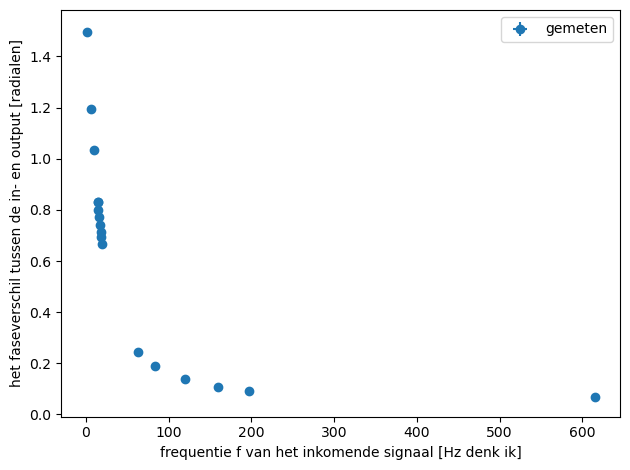

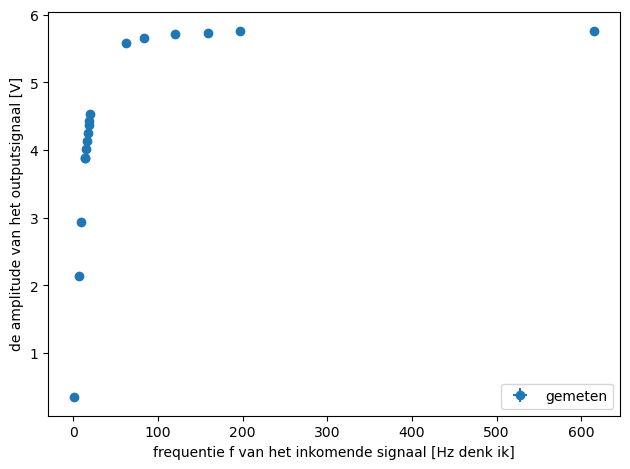

In [4]:
mypath = "RLC proef/CR"
namen, datalijst = get_data_from_folder(mypath)

fase = [] #het faseverschil tussen het in-en outputsignaal
fasefout = []

input_f = [] #frequentie (!= hoekfrequentie) van het inputsignaal
input_f_fout = []

amplitude = [] #de amplitude van het outputsignaal
amplitudefout = []
for indx in range(len(datalijst)):
    freqgok = float(namen[indx].replace('CRkring - freq','').replace('.txt',''))
    dataset = datalijst[indx]
    tijden, CH1, CH2 = dataset
    print('input bij freq', freqgok)
    inputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH1, np.full(np.shape(CH1), 0.1),freqgok = freqgok, plotting = False, detailed_logs=False))
    print('output bij freq', freqgok)
    outputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH2, np.full(np.shape(CH2), 0.1), freqgok = freqgok, plotting = False, detailed_logs=False))
    hoek = outputsinus[2][0] - inputsinus[2][0]
    hoekfout = np.sqrt(outputsinus[2][1]**2+inputsinus[2][1]**2)
    while -np.pi > hoek:
        hoek += 2*np.pi
    while hoek > np.pi:
        hoek -= 2*np.pi
    fase.append(hoek)
    fasefout.append(hoekfout)
    input_f.append(inputsinus[1][0]/2*np.pi)
    input_f_fout.append(inputsinus[1][1]/2*np.pi)
    amplitude.append(outputsinus[0][0])
    amplitudefout.append(outputsinus[0][1])

#de faseplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('het faseverschil tussen de in- en output [radialen]')
ax.legend()
plt.tight_layout()
plt.show()
#de amplitudeplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('de amplitude van het outputsignaal [V]')
ax.legend()
plt.tight_layout()
plt.show()

input bij freq 100.0
[[5.740903564288492, 5.779944708288492], [642.8551124230597, 643.0881671910598], [2.2897472612798193, 2.2966018132798194], [0.49054417858948784, 0.5179623865894879]]
A heeft als waarde: 5.7604 + 0.019521 - 0.019521 met 68% betrouwbaarheidsinterval: [5.7409, 5.7799] 
k heeft als waarde: 642.97 + 0.11653 - 0.11653 met 68% betrouwbaarheidsinterval: [642.86, 643.09] 
phi heeft als waarde: 2.2932 + 0.0034273 - 0.0034273 met 68% betrouwbaarheidsinterval: [2.2897, 2.2966] 
C heeft als waarde: 0.50425 + 0.013709 - 0.013709 met 68% betrouwbaarheidsinterval: [0.49054, 0.51796] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.06048
output bij freq 100.0
[[5.719780158099236, 5.7588213020992365], [642.8533219614225, 643.0862277174225], [2.373248022147317, 2.380102574147317], [-0.02732771569382817, 9.049230617182852e-05]]
A heeft als waarde: 5.7393 + 0.019521 - 0.019521 met 68% betrouwbaarheidsinterval: [5.7198

C:\Users\User\AppData\Local\Temp\ipykernel_28784\4179346396.py:56: RuntimeWarning: divide by zero encountered in divide
  fase = np.arctan((1-omega**2*L*C)/(omega*R*C))


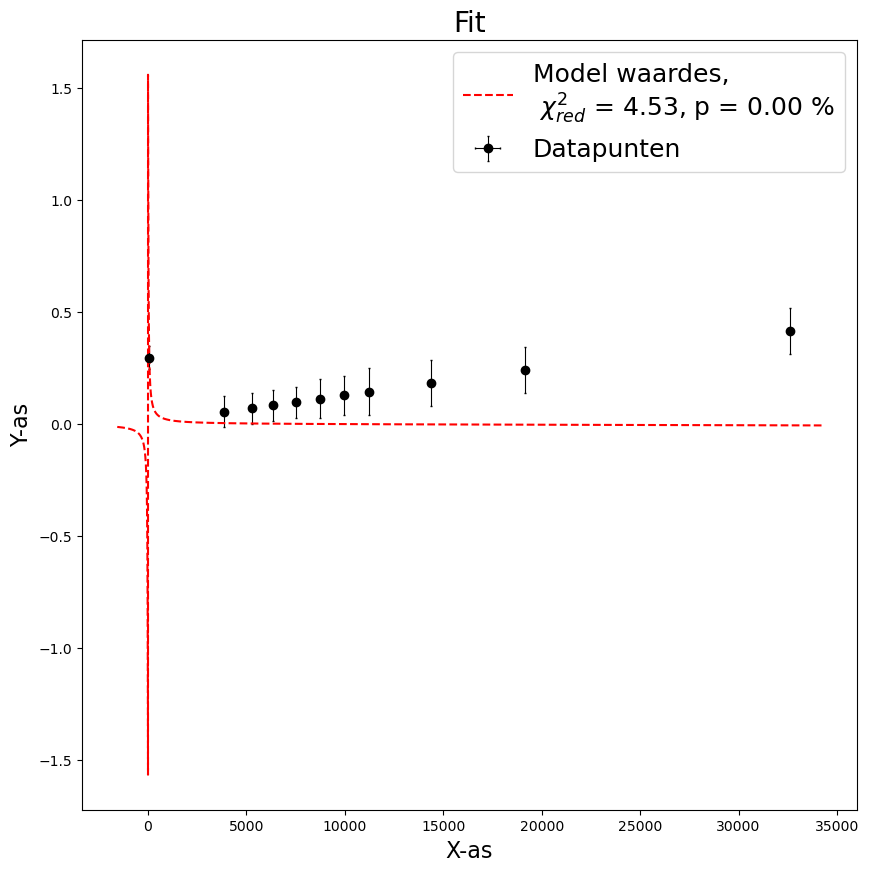

C:\Users\User\AppData\Local\Temp\ipykernel_28784\4179346396.py:158: RuntimeWarning: divide by zero encountered in divide
  tanphilinspace = (1-omegalinspace**2*L*C)/(omegalinspace*R*C)


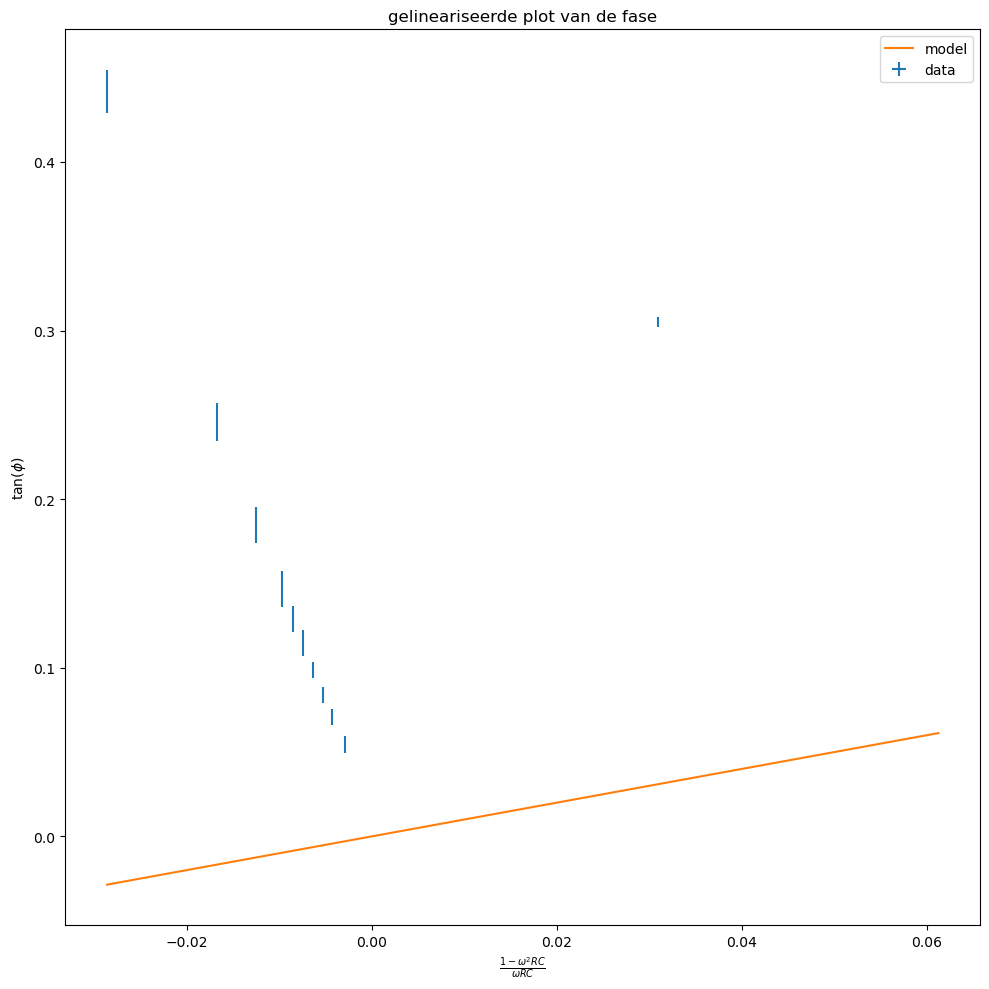

C:\Users\User\AppData\Local\Temp\ipykernel_28784\4179346396.py:51: RuntimeWarning: invalid value encountered in sqrt
  spanning = V0*R/np.sqrt(R**2+(omega*L-1/(omega*C)**2))


[5.766281674666878, 10000.0, 0.0088, 5e-05]
[5.76628167e+00 1.00000000e+04 8.80000000e-03 5.00000000e-05
 6.34587573e+03 7.53491663e+03 8.75753415e+03 9.93507508e+03
 1.12409239e+04 6.44480848e+01 1.43815804e+04 1.91659658e+04
 3.26031647e+04 3.86648809e+03 5.30005686e+03]
gok: [5.76628167e+00 1.00000000e+04 8.80000000e-03 5.00000000e-05
 6.34587573e+03 7.53491663e+03 8.75753415e+03 9.93507508e+03
 1.12409239e+04 6.44480848e+01 1.43815804e+04 1.91659658e+04
 3.26031647e+04 3.86648809e+03 5.30005686e+03]
bounds: None
<function find_sigma_values_2D.<locals>.<lambda> at 0x00000228176BB560>
<function find_sigma_values_2D.<locals>.<lambda> at 0x00000228187D2340>
<function find_sigma_values_2D.<locals>.<lambda> at 0x00000228187D2340>
<function find_sigma_values_2D.<locals>.<lambda> at 0x00000228187D2340>
<function find_sigma_values_2D.<locals>.<lambda> at 0x00000228187D2340>
<function find_sigma_values_2D.<locals>.<lambda> at 0x00000228187D2340>
<function find_sigma_values_2D.<locals>.<lambd

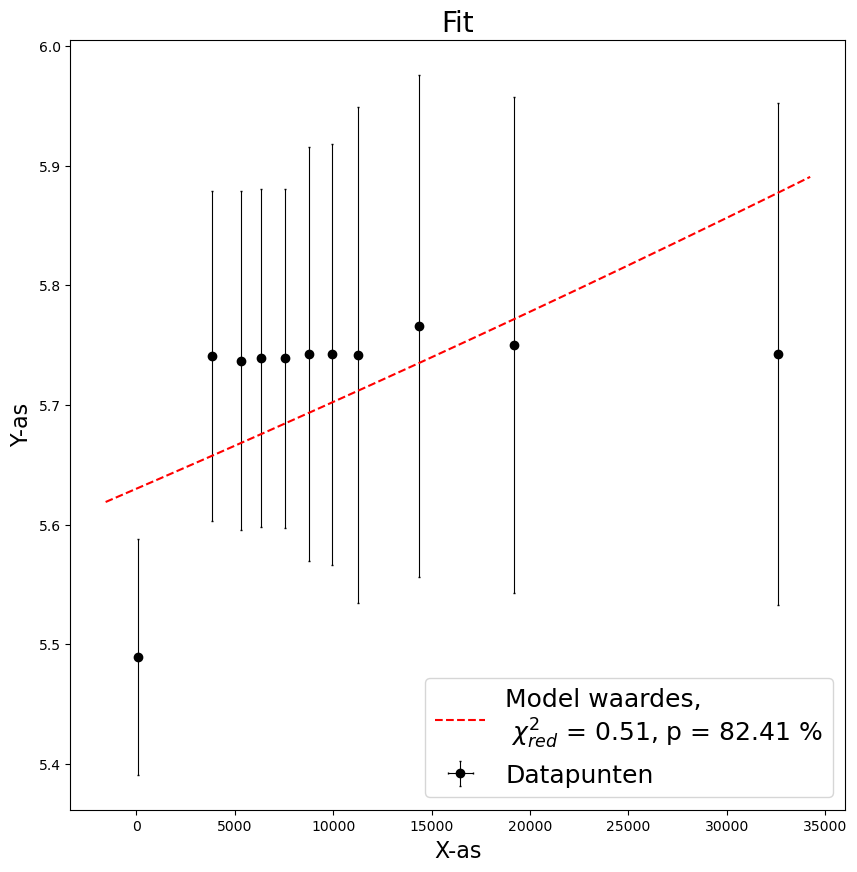

[[5.630041302942167, 0.09967258508924015, 'S'], [9999.976459824182, (10004.976459824182, -9994.976459824182), 'S'], [-252.7933667350611, -285.9262929138466, 'S'], [1.0098533918657235, (6.0098533918657235, 3.9901466081342765), 'S']]


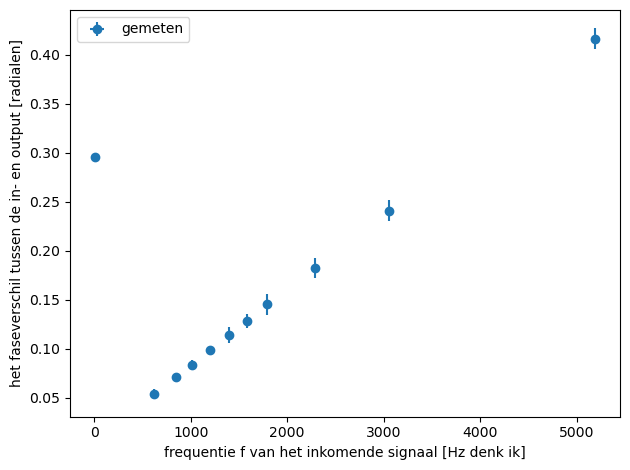

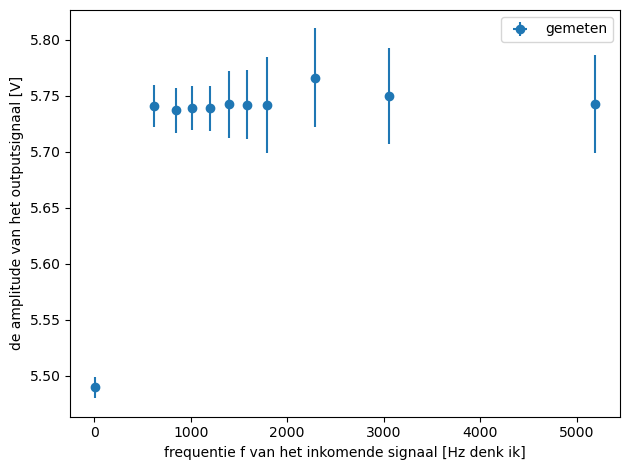

In [5]:
mypath = "RLC proef/RLC1"
namen, datalijst = get_data_from_folder(mypath)

fase = [] #het faseverschil tussen het in-en outputsignaal
fasefout = []

input_f = [] #frequentie (!= hoekfrequentie) van het inputsignaal
input_f_fout = []

amplitude = [] #de amplitude van het outputsignaal
amplitudefout = []
for indx in range(len(datalijst)):
    freqgok = float(namen[indx].replace('RLCkring - ','').replace('Hz.txt',''))
    dataset = datalijst[indx]
    tijden, CH1, CH2 = dataset
    print('input bij freq', freqgok)
    inputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH1, np.full(np.shape(CH1), 0.1),freqgok = freqgok, plotting = False, detailed_logs=False))
    print('output bij freq', freqgok)
    outputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH2, np.full(np.shape(CH2), 0.1), freqgok = freqgok, plotting = False, detailed_logs=False))
    #dus basically: de code fit insane goed, maar het duurt wel een volle minuut
    hoek = outputsinus[2][0] - inputsinus[2][0]
    hoekfout = np.sqrt(outputsinus[2][1]**2+inputsinus[2][1]**2)
    while -np.pi > hoek:
        hoek += 2*np.pi
    while hoek > np.pi:
        hoek -= 2*np.pi
    fase.append(hoek)
    fasefout.append(hoekfout)
    input_f.append(inputsinus[1][0]/2*np.pi)
    input_f_fout.append(inputsinus[1][1]/2*np.pi)
    amplitude.append(outputsinus[0][0])
    amplitudefout.append(outputsinus[0][1])
input_f = np.array(input_f)
input_f_fout = np.array(input_f_fout)
print('GEFIT:')
outp_fase = fit_fase_RLC(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout, invals = [10e3, 4*2.2e-3, 5*10e-6], bounds = [(1e3,1e5), (1e-3,2e-2),(0,1e-4)])
plot_fase_RLC_gelineariseerd(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout, [[10e3], [4*2.2e-3], [5*10e-6]])
print(fit_spanning_RLC(input_f*2*np.pi, amplitude, input_f_fout*2*np.pi, amplitudefout,invals = [max(amplitude), 10e3, 4*2.2e-3, 5*10e-6]))

#de faseplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('het faseverschil tussen de in- en output [radialen]')
ax.legend()
plt.tight_layout()
plt.show()
#de amplitudeplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('de amplitude van het outputsignaal [V]')
ax.legend()
plt.tight_layout()
plt.show()

input bij freq 100.0
[[4.1894182344863165, 4.228161354486316], [652.8415769332637, 653.1626977932636], [-1.5130086694762714, -1.5037699254762713], [0.49705038285690717, 0.5244685908569072]]
A heeft als waarde: 4.2088 + 0.019372 - 0.019372 met 68% betrouwbaarheidsinterval: [4.1894, 4.2282] 
k heeft als waarde: 653 + 0.16049 - 0.16063 met 68% betrouwbaarheidsinterval: [652.84, 653.16] 
phi heeft als waarde: -1.5084 + 0.0046194 - 0.0046194 met 68% betrouwbaarheidsinterval: [-1.513, -1.5038] 
C heeft als waarde: 0.51076 + 0.013709 - 0.013709 met 68% betrouwbaarheidsinterval: [0.49705, 0.52447] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.025349
output bij freq 100.0
[[3.101136752258132, 3.1401778962581317], [652.7821992596713, 653.2100127116713], [-1.2519848747313655, -1.2394678667313654], [-0.030308727292152376, -0.0028905192921523763]]
A heeft als waarde: 3.1207 + 0.019521 - 0.019521 met 68% betrouwbaarheidsinterval

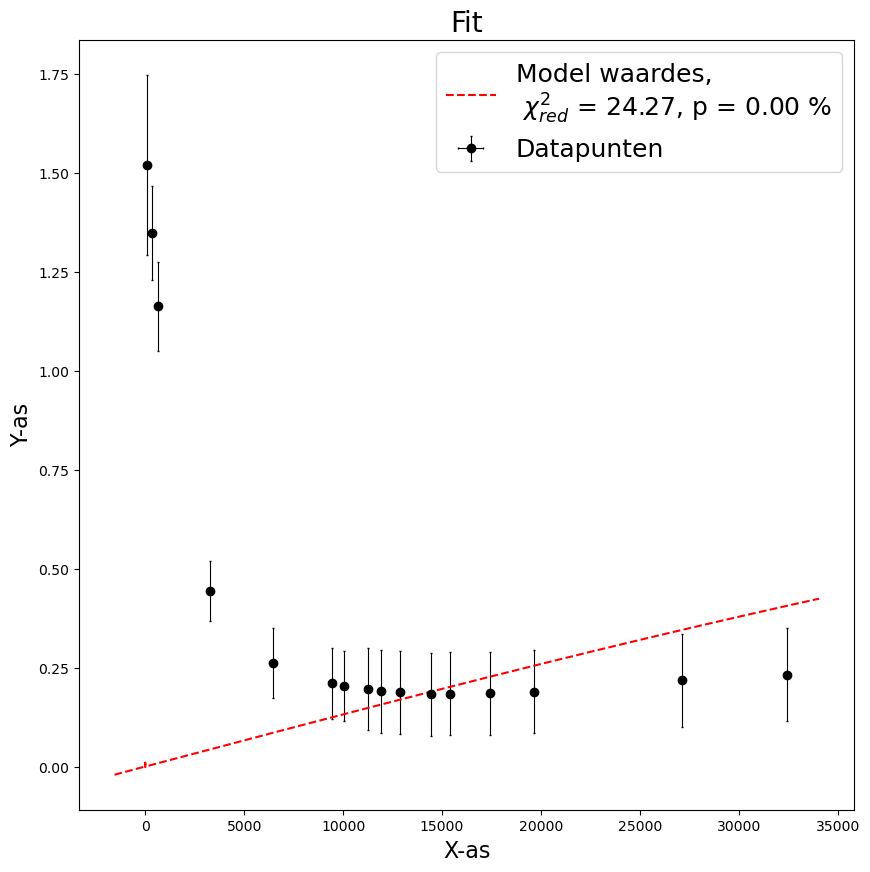

[[4230.859347312575, (953.1375250329829, 1654.9871229722003), 'S'], [-0.05606775372339235, -0.015764655363561315, 'S'], [-0.5114139361969647, 5.5114139361969645, 'S']]


C:\Users\User\AppData\Local\Temp\ipykernel_28784\4179346396.py:158: RuntimeWarning: divide by zero encountered in divide
  tanphilinspace = (1-omegalinspace**2*L*C)/(omegalinspace*R*C)


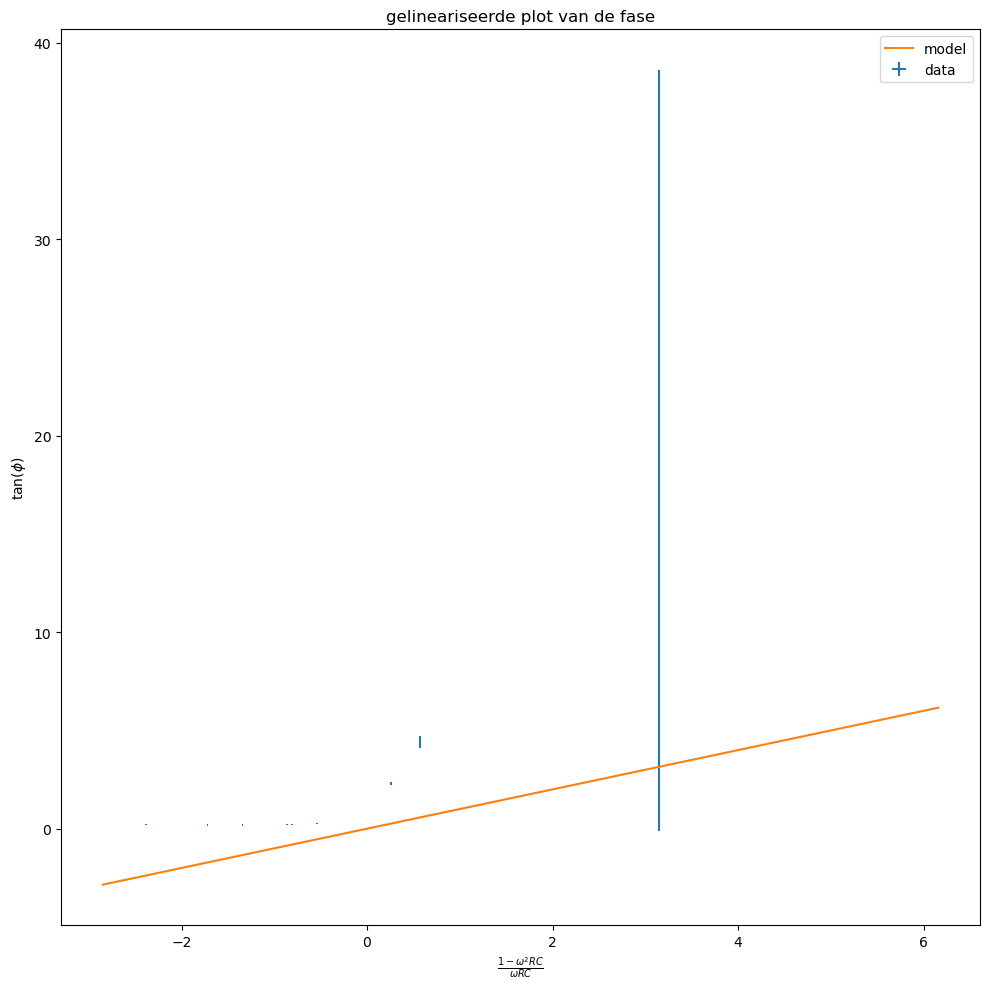

[3.147347036733829, 100, 0.0088, 5e-05]
[3.14734704e+00 1.00000000e+02 8.80000000e-03 5.00000000e-05
 6.44487350e+03 6.42003132e+02 9.44763081e+03 1.00619179e+04
 1.12433787e+04 1.19181283e+04 6.34782016e+01 1.28982852e+04
 1.44156118e+04 1.54032311e+04 1.74404092e+04 1.96617270e+04
 2.71368445e+04 3.24321987e+04 3.26952900e+03 3.35170196e+02]
gok: [3.14734704e+00 1.00000000e+02 8.80000000e-03 5.00000000e-05
 6.44487350e+03 6.42003132e+02 9.44763081e+03 1.00619179e+04
 1.12433787e+04 1.19181283e+04 6.34782016e+01 1.28982852e+04
 1.44156118e+04 1.54032311e+04 1.74404092e+04 1.96617270e+04
 2.71368445e+04 3.24321987e+04 3.26952900e+03 3.35170196e+02]
bounds: None
<function find_sigma_values_2D.<locals>.<lambda> at 0x00000228196A7CE0>
<function find_sigma_values_2D.<locals>.<lambda> at 0x000002281888ACA0>
<function find_sigma_values_2D.<locals>.<lambda> at 0x0000022818889620>
<function find_sigma_values_2D.<locals>.<lambda> at 0x00000228188885E0>
[[2.8326123330604465, 3.147347036733829], 

C:\Users\User\AppData\Local\Temp\ipykernel_28784\4179346396.py:51: RuntimeWarning: invalid value encountered in sqrt
  spanning = V0*R/np.sqrt(R**2+(omega*L-1/(omega*C)**2))
c:\Users\User\Documents\Cas\Unif\2e can\experimentele\github\Experimentele_vscode\functies.py:717: RuntimeWarning: divide by zero encountered in scalar divide
  if fout[0]/fout[1] < 1.25 and fout[0]/fout[1] > 0.8:


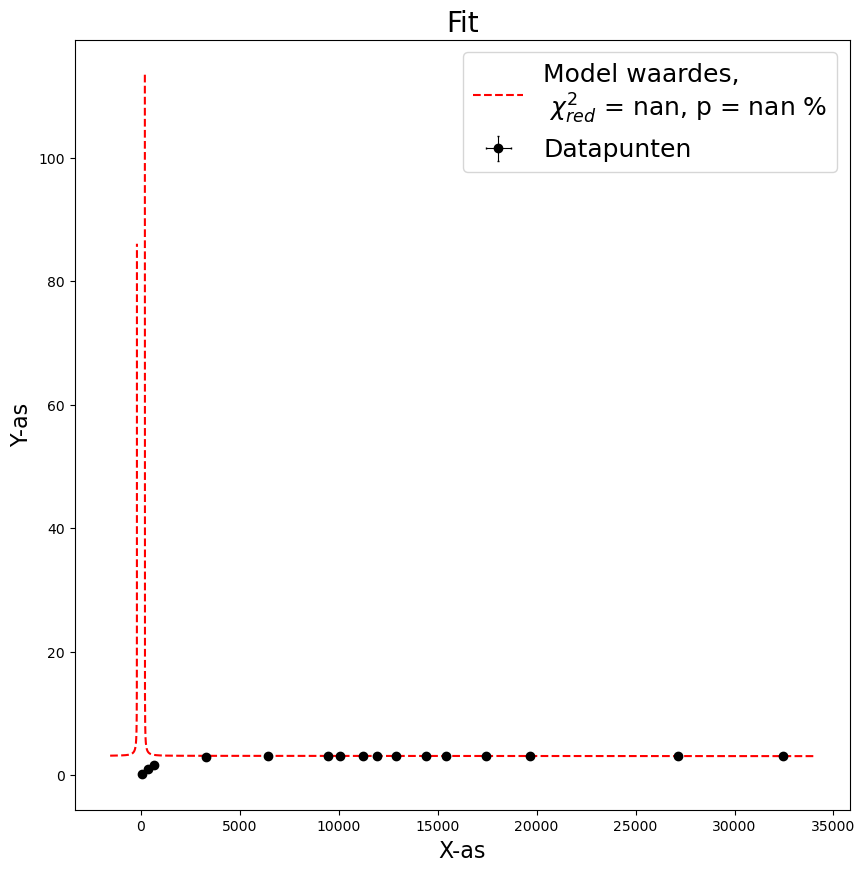

[[3.147347036733829, (0.31473470367338274, 0.0), 'S'], [100.0, (10.0, 0.0), 'S'], [0.0088, (0.0008800000000000006, 0.0), 'S'], [5e-05, (4.9999999999999996e-06, 0.0), 'S']]


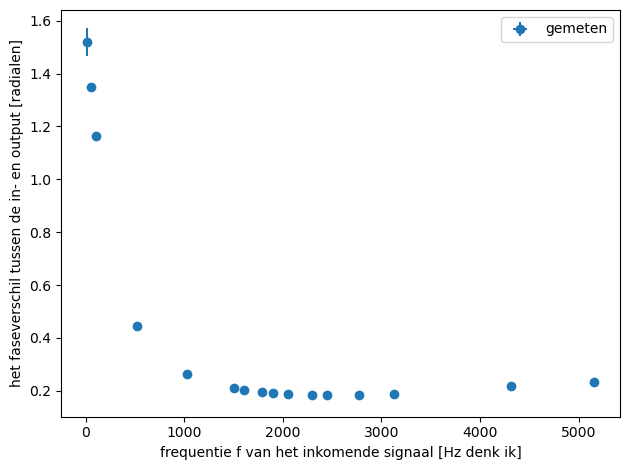

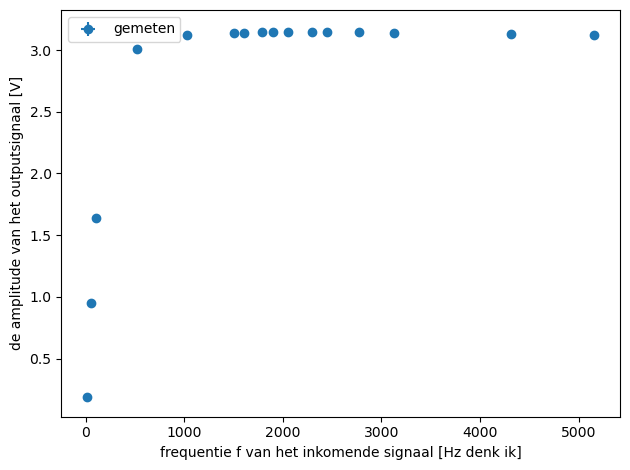

In [6]:
mypath = "RLC proef/RLC2"
namen, datalijst = get_data_from_folder(mypath)

fase = [] #het faseverschil tussen het in-en outputsignaal
fasefout = []

input_f = [] #frequentie (!= hoekfrequentie) van het inputsignaal
input_f_fout = []

amplitude = [] #de amplitude van het outputsignaal
amplitudefout = []
for indx in range(len(datalijst)):
    freqgok = float(namen[indx].replace('RLC2 - ','').replace('Hz.txt',''))
    dataset = datalijst[indx]
    tijden, CH1, CH2 = dataset
    print('input bij freq', freqgok)
    inputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH1, np.full(np.shape(CH1), 0.1),freqgok = freqgok, plotting = False, detailed_logs=False))
    print('output bij freq', freqgok)
    outputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH2, np.full(np.shape(CH2), 0.1), freqgok = freqgok, plotting = False, detailed_logs=False))
    #de fits zijn insane ze duren wederom een volle minuut tho
    hoek = outputsinus[2][0] - inputsinus[2][0]
    hoekfout = np.sqrt(outputsinus[2][1]**2+inputsinus[2][1]**2)
    while -np.pi > hoek:
        hoek += 2*np.pi
    while hoek > np.pi:
        hoek -= 2*np.pi
    fase.append(hoek)
    fasefout.append(hoekfout)
    input_f.append(inputsinus[1][0]/2*np.pi)
    input_f_fout.append(inputsinus[1][1]/2*np.pi)
    amplitude.append(outputsinus[0][0])
    amplitudefout.append(outputsinus[0][1])
input_f = np.array(input_f)
input_f_fout = np.array(input_f_fout)
#de faseplot
print('GEFIT:')
print(fit_fase_RLC(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout, invals = [100, 4*2.2e-3, 5*10e-6]))
plot_fase_RLC_gelineariseerd(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout, [[100], [4*2.2e-3], [5*10e-6]])
print(fit_spanning_RLC(input_f*2*np.pi, amplitude, input_f_fout*2*np.pi, amplitudefout,invals = [max(amplitude), 100, 4*2.2e-3, 5*10e-6]))
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('het faseverschil tussen de in- en output [radialen]')
ax.legend()
plt.tight_layout()
plt.show()
#de amplitudeplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('de amplitude van het outputsignaal [V]')
ax.legend()
plt.tight_layout()
plt.show()